In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import csv

from hyperopt import fmin
from hyperopt import hp
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer

from timeit import default_timer as timer

import sdss_gz_data as sgd
from sdss_gz_data import SPIRIAL_GALAXY_TYPE
from sdss_gz_data import ELLIPTICAL_GALAXY_TYPE
from sdss_gz_data import UNKNOWN_GALAXY_TYPE

from joblib import Parallel, delayed

/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
features = sgd.generate_features()
features

['dered_u',
 'petroRad_u',
 'petroR50_u',
 'petroR90_u',
 'petro_R90_R50_ratio_u',
 'petroMag_u',
 'expRad_u',
 'deVRad_u',
 'psfMag_u',
 'expMag_u',
 'fiberMag_u',
 'extinction_u',
 'expAB_u',
 'expPhi_u',
 'deVAB_u',
 'deVPhi_u',
 'mag_u',
 'stokes_q_u',
 'stokes_u_u',
 'dered_g',
 'petroRad_g',
 'petroR50_g',
 'petroR90_g',
 'petro_R90_R50_ratio_g',
 'petroMag_g',
 'expRad_g',
 'deVRad_g',
 'psfMag_g',
 'expMag_g',
 'fiberMag_g',
 'extinction_g',
 'expAB_g',
 'expPhi_g',
 'deVAB_g',
 'deVPhi_g',
 'mag_g',
 'stokes_q_g',
 'stokes_u_g',
 'petro_g_u_colour_index',
 'model_g_u_colour_index',
 'psfMag_g_u_colour_index',
 'dered_i',
 'petroRad_i',
 'petroR50_i',
 'petroR90_i',
 'petro_R90_R50_ratio_i',
 'petroMag_i',
 'expRad_i',
 'deVRad_i',
 'psfMag_i',
 'expMag_i',
 'fiberMag_i',
 'extinction_i',
 'expAB_i',
 'expPhi_i',
 'deVAB_i',
 'deVPhi_i',
 'mag_i',
 'stokes_q_i',
 'stokes_u_i',
 'petro_i_r_colour_index',
 'model_i_r_colour_index',
 'psfMag_i_r_colour_index',
 'dered_r',
 'petroR

In [4]:
%ls -l data/

total 1651496
-rw-r--r--@ 1 will  staff      42029  6 Apr 20:34 1237648720693755918.png
-rw-r--r--@ 1 will  staff      48342  6 Apr 20:34 1237648720693756035.png
-rw-r--r--@ 1 will  staff      36069  6 Apr 20:34 1237648720693756115.png
-rw-r--r--@ 1 will  staff      37825  6 Apr 20:34 1237648720693756163.png
-rw-r--r--@ 1 will  staff      37626  6 Apr 20:34 1237648720693756176.png
-rw-r--r--@ 1 will  staff  349816837 11 Mar 15:14 astromonical_data.csv.gz
drwxr-xr-x  4 will  staff        128  6 Apr 16:18 fits/
-rw-r--r--  1 will  staff   12208320  6 Apr 20:34 frame-g-000756-2-0427.fits
-rw-r--r--  1 will  staff   12208320  6 Apr 20:34 frame-i-000756-2-0427.fits
-rw-r--r--  1 will  staff   12208320  6 Apr 20:34 frame-r-000756-2-0427.fits
-rw-r--r--@ 1 will  staff  319952110 31 Jan 20:01 input.csv
-rw-r--r--  1 will  staff    4320000  6 Apr 20:34 obj-1237648720693755918.fits
-rw-r--r--  1 will  staff    4320000  6 Apr 20:34 obj-1237648720693756035.fits
-rw-r--r--  1 will  staff    4320000

In [5]:
orig_data = sgd.load_data('data/astromonical_data.csv.gz')

In [6]:
prepared_data = sgd.prepare_data(orig_data)

Filtered out 3501 invalid records
Number of high z galaxies = 231
% elliptical:      0.13576908942272356
% spiral:          0.2237143092857732
% unknown:         0.6405166012915032
% spiral of known: 0.6223216707350149


In [7]:
transformed_data = sgd.transform_data(prepared_data)

In [8]:
X = transformed_data[features]
y = transformed_data['galaxy_type']

In [9]:
len(transformed_data)

533332

In [10]:
y_visualisation = y.map({SPIRIAL_GALAXY_TYPE: 'Spiral', ELLIPTICAL_GALAXY_TYPE: 'Ellipitcal', UNKNOWN_GALAXY_TYPE: 'Unknown'})
print("Percent Class Distribution:")
print(y_visualisation.value_counts(normalize=True)*100)

Percent Class Distribution:
Unknown       64.051660
Spiral        22.371431
Ellipitcal    13.576909
Name: galaxy_type, dtype: float64


In [11]:
known_galaxy_type_idx = transformed_data.galaxy_type != sgd.UNKNOWN_GALAXY_TYPE

X = X[known_galaxy_type_idx]
y = y[known_galaxy_type_idx]

In [12]:
len(X)

191724

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Hyperparameter Search

In [16]:
N_FOLDS = 5

hp_out_file = 'gbm_hp_trials.csv'
of_connection = open(hp_out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

def objective(x_train, y_train, random_state=42, stratified=True):
    def _objective(params, n_folds=N_FOLDS):
        # Keep track of evals
        global ITERATION

        ITERATION += 1

#         # Retrieve the subsample
#         subsample = params['boosting_type'].get('subsample', 1.0)

#         # Extract the boosting type and subsample to top level keys
#         params['boosting_type'] = params['boosting_type']['boosting_type']
#         params['subsample'] = subsample

        # Make sure parameters that need to be integers are integers
        for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
            params[parameter_name] = int(params[parameter_name])

        params['boosting_type'] = 'gbdt'
        train_set = lgb.Dataset(x_train, y_train)
        
        start = timer()
        cv_results = lgb.cv(params, train_set, nfold=n_folds, num_boost_round=1000,
                           early_stopping_rounds=100,
                           metrics='auc', seed=random_state, stratified=stratified)
        run_time = timer() - start

        best_score = max(cv_results['auc-mean'])

        # need a function to minimise
        loss = 1 - best_score
        
        # Boosting rounds that returned the highest cv score
        n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

        if ITERATION % 10 == 0:
            # Display the information
            display('Iteration {}: {} Fold CV AUC ROC {:.5f}'.format(ITERATION, N_FOLDS, best_score))

        of_connection = open(hp_out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow([loss, params, ITERATION, n_estimators, run_time])
        of_connection.close()

        # Dictionary with information for evaluation
        return {'loss': loss, 'params': params, 'iteration': ITERATION,
                'estimators': n_estimators, 
                'train_time': run_time, 'status': STATUS_OK}

    return _objective

In [17]:
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [ ]:
ITERATION = 0
MAX_EVALS = 10

tpe_algorithm = tpe.suggest
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective(x_train, y_train), space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)

In [ ]:
best

In [ ]:
hyperparams = bayes_trials.best_trial['result']['params']
hyperparams['class_weight'] = None
hyperparams

## K-Folds

In [14]:
hyperparams = {
    'class_weight': 'balanced',
    'num_leaves': 150,
    'learning_rate': 0.1,
#    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
#    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
#    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
#    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
#    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [15]:
N_FOLDS = 5

#learning_rate = 0.1
def kfolds(x_train, x_test, y_train, y_test, n_splits=N_FOLDS, random_state=1138, verbose=True, features=None):
    if (features is not None):
        x_train = x_train[features]
        x_test = x_test[features]

    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds = np.zeros(x_train.shape[0])
    predictions = np.zeros(x_test.shape[0])
    
    models = []
    
    for n_fold, (train_index, validate_index) in enumerate(folds.split(x_train, y_train)):
        X_t, X_v = x_train.iloc[train_index], x_train.iloc[validate_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[validate_index]

        clf = lgb.LGBMClassifier(
            objective='binary',
            **hyperparams
        )

        clf.fit(X_t, y_t, eval_set=[(X_v, y_v)],
                early_stopping_rounds=100,
                eval_metric='auc',
                verbose=False,
        )

        oof_preds[validate_index] = clf.predict_proba(X_v, num_iteration=clf.best_iteration_)[:, 1]
        predictions += clf.predict_proba(x_test, num_iteration=clf.best_iteration_)[:, 1]/N_FOLDS

        if (verbose):
            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(y_v, oof_preds[validate_index])))
            
        models.append(clf)
        del clf, X_t, X_v, y_t, y_v

    result = roc_auc_score(y_train, oof_preds)
    if (verbose):
        print(f'Full AUC score {result:0.6f}')
    return result, models

In [16]:
def predict(models, x_test, features=None):
    if (features is not None):
        x_test = x_test[features]

    num_of_models = len(models)
    predictions = np.zeros(x_test.shape[0])

    for idx, model in enumerate(models):
        predictions += model.predict_proba(x_test, num_iteration=model.best_iteration_)[:, 1]/num_of_models

    return predictions

In [315]:
_ = kfolds(x_train, x_test, y_train, y_test)

Fold  1 AUC : 0.999148
Fold  2 AUC : 0.999159
Fold  3 AUC : 0.999133
Fold  4 AUC : 0.999290
Fold  5 AUC : 0.999143
Full AUC score 0.999164


(0.9991638341017863,
 [LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
          colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
          max_depth=-1, min_child_samples=20, min_child_weight=0.001,
          min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=150,
          objective='binary', random_state=None, reg_alpha=0.0,
          reg_lambda=0.0, silent=True, subsample=1.0,
          subsample_for_bin=200000, subsample_freq=0),
  LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
          colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
          max_depth=-1, min_child_samples=20, min_child_weight=0.001,
          min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=150,
          objective='binary', random_state=None, reg_alpha=0.0,
          reg_lambda=0.0, silent=True, subsample=1.0,
          subsample_for_bin=200000, subsample_freq=0),
  LGBMClassifier(boosting_type='gbdt', class_weight='balanced',

In [17]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

NO_BEST_FEATURE = ''
NO_BEST_AUC = -1

def get_feature_score(features):
    auc, models = kfolds(x_train[features], x_test[features], y_train, y_test, verbose=False)
    return auc

# Model colour indexes are the base features. Everything else additional
def determine_best_features(base_features, base_auc, bad_features):
#    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    def best_auc_results(results):
        if (len(results) == 0):
            return NO_BEST_FEATURE, NO_BEST_AUC

        best_feature, best_auc = max(results.items(), key=lambda x:x[1])
        return best_feature, best_auc

    def process(results):
        def _process(feature):
            print(f'Checking feature: {feature}')
            run_features = base_features.copy()
            run_features.add(feature)

            curr_auc = get_feature_score(run_features)

            if (curr_auc < base_auc):
                print(f'WARNING - {feature} reduces model accuracy!!!')
                bad_features.add(feature)
            else:
                results[feature] = curr_auc
            
                best_feature, best_auc = best_auc_results(results)
                if (best_feature == feature):
                    print(f'{feature} has best AUC score {curr_auc:0.6f}')

            return (curr_auc, feature)

        return _process
    
    print(f'Base AUC: {base_auc:0.6f}')

    features_to_scan = set(features)
    features_to_scan = features_to_scan.difference(base_features).difference(bad_features)
    
    results = {}

    print(f'Checking {len(features_to_scan)} features... this might take awhile')
    process_feature = process(results)
    _ = Parallel(n_jobs=num_cores, verbose=1, backend="threading")(map(delayed(process_feature), features_to_scan))
    
    best_feature, best_auc = best_auc_results(results)

    return results, best_auc, best_feature

In [21]:
# base_features = set(['model_u_g_colour_index',
#                  'model_g_r_colour_index',
#                  'model_r_i_colour_index',
#                  'model_i_z_colour_index',
#                 ])
base_features = set([
#     'psfMag_r',
#     'psfMag_g_u_colour_index',
#     'psfMag_r_g_colour_index',
#     'psfMag_i_r_colour_index',
#     'psfMag_z_i_colour_index',
#                     'expRad_g',
#                     'petroR50_i',
#                     'petroRad_r',
#                     'deVAB_r',
#                     'petro_g_r_colour_index',
#                     'petro_R90_R50_ratio_g',
#                     'model_r_i_colour_index',
#                     'expAB_g',
#                     'petro_R90_R50_ratio_r',
#                     'fracDeV_i',
#                     'model_u_g_colour_index',
#                     'expAB_z',
#                     'expAB_i',
#                     'petroRad_g'
                ])
#base_auc = get_feature_score(list(base_features))
base_auc = 0.998908

extra_base_features = ['expRad_g', 'petroR90_i', 'petro_r_g_colour_index', 'mag_g', 'deVAB_i', 'petroRad_r', 'model_i_r_colour_index', 'petro_R90_R50_ratio_g', 'expAB_g', 'psfMag_r']
#all_bad_features = set([])

for idx in range(5):
    base_features.update(extra_base_features)
    print(f'Starting a round {idx} to find best feature. Current extra features = {extra_base_features}')
    feature_results, best_auc, best_feature = determine_best_features(base_features, base_auc, all_bad_features)
    
    if (best_feature == NO_BEST_FEATURE):
        print('No new feature found. Exiting')
        break
    
    print(f'Found {best_feature} as extra feature')
    extra_base_features.append(best_feature)
    base_auc = best_auc

base_features.update(extra_base_features)
print(f'Final extra features = {extra_base_features}')

Starting a round 0 to find best feature. Current extra features = ['expRad_g', 'petroR90_i', 'petro_r_g_colour_index', 'mag_g', 'deVAB_i', 'petroRad_r', 'model_i_r_colour_index', 'petro_R90_R50_ratio_g', 'expAB_g', 'psfMag_r']
Base AUC: 0.998908
Checking 39 features... this might take awhile
Checking feature: expMag_uChecking feature: psfMag_iChecking feature: petro_R90_R50_ratio_z


Checking feature: psfMag_g_u_colour_index


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


expMag_u has best AUC score 0.998910
Checking feature: expRad_i
WARNING - psfMag_i reduces model accuracy!!!
Checking feature: petroR50_i
WARNING - psfMag_g_u_colour_index reduces model accuracy!!!
Checking feature: expRad_z
petro_R90_R50_ratio_z has best AUC score 0.998944
Checking feature: expRad_u
Checking feature: petroRad_i
petroR50_i has best AUC score 0.998948
Checking feature: deVRad_z
Checking feature: petro_R90_R50_ratio_i
Checking feature: deVRad_i
Checking feature: expMag_z
Checking feature: model_r_g_colour_index
petro_R90_R50_ratio_i has best AUC score 0.998962
Checking feature: dered_u
Checking feature: fiberMag_r
Checking feature: model_g_u_colour_index
Checking feature: expMag_r
WARNING - dered_u reduces model accuracy!!!
Checking feature: deVRad_r
WARNING - fiberMag_r reduces model accuracy!!!
Checking feature: petroR50_z
Checking feature: fiberMag_u
WARNING - expMag_r reduces model accuracy!!!
Checking feature: extinction_u
Checking feature: deVRad_g
Checking feature

[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed: 11.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found petro_R90_R50_ratio_i as extra feature
Starting a round 1 to find best feature. Current extra features = ['expRad_g', 'petroR90_i', 'petro_r_g_colour_index', 'mag_g', 'deVAB_i', 'petroRad_r', 'model_i_r_colour_index', 'petro_R90_R50_ratio_g', 'expAB_g', 'psfMag_r', 'petro_R90_R50_ratio_i']
Base AUC: 0.998962
Checking 30 features... this might take awhile
Checking feature: expMag_uChecking feature: petro_R90_R50_ratio_z

Checking feature: expRad_iChecking feature: petroR50_i

petroR50_i has best AUC score 0.998975
Checking feature: expRad_z
expRad_i has best AUC score 0.998998
Checking feature: expRad_u
Checking feature: petroRad_i
Checking feature: deVRad_z
Checking feature: deVRad_i
Checking feature: expMag_z
Checking feature: model_r_g_colour_index
Checking feature: model_g_u_colour_index
deVRad_i has best AUC score 0.999005
Checking feature: deVRad_r
Checking feature: petroR50_z
Checking feature: extinction_u
model_g_u_colour_index has best AUC score 0.999023
Checking feature:

[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  9.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found model_g_u_colour_index as extra feature
Starting a round 2 to find best feature. Current extra features = ['expRad_g', 'petroR90_i', 'petro_r_g_colour_index', 'mag_g', 'deVAB_i', 'petroRad_r', 'model_i_r_colour_index', 'petro_R90_R50_ratio_g', 'expAB_g', 'psfMag_r', 'petro_R90_R50_ratio_i', 'model_g_u_colour_index']
Base AUC: 0.999023
Checking 29 features... this might take awhile
Checking feature: expMag_uChecking feature: petro_R90_R50_ratio_z
Checking feature: expRad_i
Checking feature: petroR50_i

expRad_i has best AUC score 0.999032
Checking feature: expRad_z
Checking feature: expRad_u
Checking feature: petroRad_i
expMag_u has best AUC score 0.999036
Checking feature: deVRad_z
expRad_z has best AUC score 0.999055
Checking feature: deVRad_i
Checking feature: expMag_z
WARNING - petroRad_i reduces model accuracy!!!
Checking feature: model_r_g_colour_index
Checking feature: deVRad_r
deVRad_i has best AUC score 0.999058
Checking feature: petroR50_z
Checking feature: extinction_u


[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:  9.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found deVRad_i as extra feature
Starting a round 3 to find best feature. Current extra features = ['expRad_g', 'petroR90_i', 'petro_r_g_colour_index', 'mag_g', 'deVAB_i', 'petroRad_r', 'model_i_r_colour_index', 'petro_R90_R50_ratio_g', 'expAB_g', 'psfMag_r', 'petro_R90_R50_ratio_i', 'model_g_u_colour_index', 'deVRad_i']
Base AUC: 0.999058
Checking 22 features... this might take awhile
Checking feature: expMag_uChecking feature: petro_R90_R50_ratio_z
Checking feature: expRad_i
Checking feature: petroR50_i

WARNING - petro_R90_R50_ratio_z reduces model accuracy!!!
Checking feature: expRad_z
WARNING - petroR50_i reduces model accuracy!!!
Checking feature: expRad_u
WARNING - expMag_u reduces model accuracy!!!
Checking feature: deVRad_z
WARNING - expRad_i reduces model accuracy!!!
Checking feature: expMag_z
WARNING - expRad_z reduces model accuracy!!!
Checking feature: model_r_g_colour_index
expRad_u has best AUC score 0.999063
Checking feature: deVRad_r
WARNING - expMag_z reduces model acc

[Parallel(n_jobs=4)]: Done  22 out of  22 | elapsed:  7.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


expRad_u has best AUC score 0.999088
Checking feature: petro_R90_R50_ratio_r
deVAB_g has best AUC score 0.999098
Checking feature: psfMag_u
WARNING - deVRad_g reduces model accuracy!!!
Checking feature: petroRad_g
expAB_z has best AUC score 0.999101
WARNING - petro_R90_R50_ratio_r reduces model accuracy!!!
Found expAB_z as extra feature
Final extra features = ['expRad_g', 'petroR90_i', 'petro_r_g_colour_index', 'mag_g', 'deVAB_i', 'petroRad_r', 'model_i_r_colour_index', 'petro_R90_R50_ratio_g', 'expAB_g', 'psfMag_r', 'petro_R90_R50_ratio_i', 'model_g_u_colour_index', 'deVRad_i', 'expAB_i', 'expAB_z']


[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed:  2.4min finished


In [18]:
base_features = set([
    'deVAB_i',
    'deVRad_i',
    'expAB_g',
    'expAB_i',
    'expAB_z',
    'expRad_g',
    'mag_g',
    'model_g_u_colour_index',
    'model_i_r_colour_index',
    'petroR90_i',
    'petroRad_r',
    'petro_R90_R50_ratio_g',
    'petro_R90_R50_ratio_i',
    'petro_r_g_colour_index',
    'psfMag_r'
])

In [26]:
base_features.intersection(set([
        'expAB_z',
        'expRad_g',
        'expRad_i',
        'expRad_u',
        'expRad_z',
        'fiberMag_g',
        'fiberMag_r',
        'fiberMag_u',
        'fiberMag_z',
        'model_g_u_colour_index',
        'model_i_r_colour_index',
        'model_r_g_colour_index',
        'model_z_i_colour_index',
        'petroR50_i',
        'petro_R90_R50_ratio_g',
        'dered_r']))

{'expAB_z',
 'expRad_g',
 'model_g_u_colour_index',
 'model_i_r_colour_index',
 'petro_R90_R50_ratio_g'}

In [67]:
extra_base_features

[autoreload of pandas.core.config_init failed: Traceback (most recent call last):
  File "/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/will/D

[autoreload of pandas.core.indexes.multi failed: Traceback (most recent call last):
  File "/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 331, in update_generic
    update(a, b)
  File "/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 279, in update_class
    if (old_obj == new_obj) is True:
  File "/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/pandas/core/indexes/frozen.py", line 91, in __eq__
    return super(FrozenList, self).__eq__(other)
TypeError: super(type, obj)

['expRad_g',
 'petroR90_i',
 'petro_r_g_colour_index',
 'mag_g',
 'deVAB_i',
 'petroRad_r',
 'model_i_r_colour_index',
 'petro_R90_R50_ratio_g',
 'expAB_g',
 'psfMag_r',
 'petro_R90_R50_ratio_i',
 'model_g_u_colour_index',
 'deVRad_i',
 'expAB_i',
 'expAB_z']

In [321]:
all_bad_features

{'deVAB_g',
 'deVAB_i',
 'deVAB_u',
 'deVAB_z',
 'deVPhi_g',
 'deVPhi_i',
 'deVPhi_r',
 'deVPhi_u',
 'deVPhi_z',
 'deVRad_g',
 'deVRad_r',
 'deVRad_u',
 'deVRad_z',
 'dered_g',
 'dered_i',
 'dered_r',
 'dered_u',
 'dered_z',
 'expAB_g',
 'expAB_i',
 'expAB_u',
 'expMag_g',
 'expMag_i',
 'expMag_r',
 'expMag_u',
 'expPhi_g',
 'expPhi_i',
 'expPhi_r',
 'expPhi_u',
 'expPhi_z',
 'expRad_i',
 'expRad_r',
 'expRad_u',
 'extinction_g',
 'extinction_i',
 'extinction_r',
 'extinction_u',
 'extinction_z',
 'fiberMag_g',
 'fiberMag_i',
 'fiberMag_r',
 'fiberMag_u',
 'fiberMag_z',
 'fracDeV_g',
 'fracDeV_i',
 'mag_g',
 'mag_i',
 'mag_r',
 'mag_u',
 'mag_z',
 'model_g_u_colour_index',
 'model_r_g_colour_index',
 'model_z_i_colour_index',
 'petroMag_g',
 'petroMag_i',
 'petroMag_r',
 'petroMag_u',
 'petroMag_z',
 'petroR50_g',
 'petroR50_r',
 'petroR50_u',
 'petroR50_z',
 'petroR90_g',
 'petroR90_i',
 'petroR90_u',
 'petroR90_z',
 'petroRad_i',
 'petroRad_u',
 'petroRad_z',
 'petro_R90_R50_ratio_r'

In [34]:
# selected_features = base_features.copy()
# selected_features.update([
#     'expAB_z',
#     'expRad_g',
#     'expRad_i',
#     'expRad_u',
#     'expRad_z',
#     'fiberMag_g',
#     'fiberMag_r',
#     'fiberMag_u',
#     'fiberMag_z',
#     'model_g_u_colour_index',
#     'model_i_r_colour_index',
#     'model_r_g_colour_index',
#     'model_z_i_colour_index',
#     'petroR50_i',
#     'petro_R90_R50_ratio_g',
#     'dered_r'
# ])
selected_features = set([
    'deVAB_i',
    'expAB_g',
    'expAB_i',
    'expAB_z',
    'expRad_g',
    'expRad_u',
    'expRad_z',
    'fiberMag_g',
    'fiberMag_u',
    'fiberMag_z',
    'model_g_u_colour_index',
    'model_i_r_colour_index',
    'model_r_g_colour_index',
    'model_z_i_colour_index',
    'petroRad_r',
    'petro_R90_R50_ratio_g',
    'petro_R90_R50_ratio_i',
    'petro_r_g_colour_index',
    'psfMag_r'
])
selected_features

{'deVAB_i',
 'expAB_g',
 'expAB_i',
 'expAB_z',
 'expRad_g',
 'expRad_u',
 'expRad_z',
 'fiberMag_g',
 'fiberMag_u',
 'fiberMag_z',
 'model_g_u_colour_index',
 'model_i_r_colour_index',
 'model_r_g_colour_index',
 'model_z_i_colour_index',
 'petroRad_r',
 'petro_R90_R50_ratio_g',
 'petro_R90_R50_ratio_i',
 'petro_r_g_colour_index',
 'psfMag_r'}

In [35]:
auc_score, models = kfolds(x_train, x_test, y_train, y_test, features=selected_features)

Fold  1 AUC : 0.999037
Fold  2 AUC : 0.999117
Fold  3 AUC : 0.998999
Fold  4 AUC : 0.999148
Fold  5 AUC : 0.999136
Full AUC score 0.999082


In [37]:
# clf = lgb.LGBMClassifier(
#         objective='binary',
#         **hyperparams
#     )
# clf.fit(x_train[base_features], y_train, verbose=True, eval_metric='auc')

# predictions = clf.predict_proba(x_test[base_features], num_iteration=clf.best_iteration_)
predictions = predict(models, x_test, features=selected_features)
print(predictions)

[5.58699958e-04 8.92751317e-01 9.99142926e-01 ... 1.52092851e-04
 1.88498928e-02 9.99638652e-01]


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

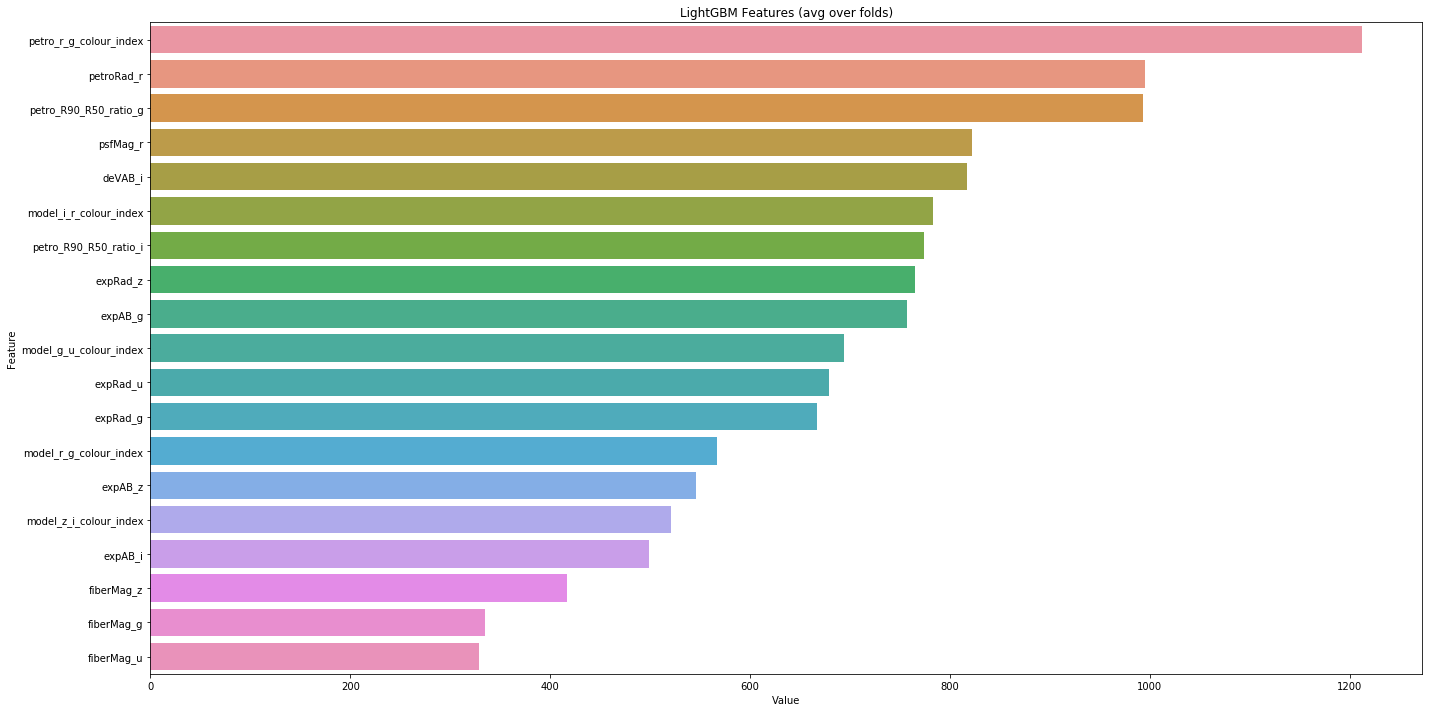

In [39]:
feature_importances = pd.DataFrame(sorted(zip(x_train[selected_features].columns, np.zeros(len(selected_features)))), columns=['Feature', 'Value'])
#feature_importances
#pd.DataFrame(sorted(zip(x_train[selected_features].columns, model.feature_importances_)), columns=['Feature', 'Value'])

# feature_importances = np.empty((len(models), len(selected_features), 2), dtype=object)
for idx, model in enumerate(models):
    feature_importance = pd.DataFrame(sorted(zip(x_train[selected_features].columns, model.feature_importances_)), columns=['Feature','Value'])
    feature_importances['Value'] += feature_importance['Value']/len(models)

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_importances.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()


In [40]:
feature_importances.sort_values(by="Value", ascending=False)

,Feature,Value
17,petro_r_g_colour_index,1211.8
14,petroRad_r,995.0
15,petro_R90_R50_ratio_g,993.4
18,psfMag_r,822.0
0,deVAB_i,817.2
11,model_i_r_colour_index,783.2
16,petro_R90_R50_ratio_i,774.4
6,expRad_z,764.6
1,expAB_g,757.2
10,model_g_u_colour_index,694.0


In [33]:
common_features = [
    'expAB_z',
    'expRad_g',
    'model_g_u_colour_index',
    'model_i_r_colour_index',
    'petro_R90_R50_ratio_g'
]
non_common_features_importance = feature_importances[np.invert(feature_importances.Feature.isin(common_features))]
non_common_features_importance.sort_values(by="Value", ascending=False)

,Feature,Value
24,petro_r_g_colour_index,1161.0
21,petroRad_r,841.2
0,deVAB_i,746.0
25,psfMag_r,719.2
23,petro_R90_R50_ratio_i,684.4
3,expAB_g,666.4
8,expRad_u,622.0
17,model_r_g_colour_index,523.6
4,expAB_i,468.0
9,expRad_z,456.0


In [41]:
predictions

array([5.58699958e-04, 8.92751317e-01, 9.99142926e-01, ...,
       1.52092851e-04, 1.88498928e-02, 9.99638652e-01])

In [42]:
pred = np.empty(predictions.shape, dtype=int)
pred[predictions < 0.5] = SPIRIAL_GALAXY_TYPE
pred[predictions >= 0.5] = ELLIPTICAL_GALAXY_TYPE
pred

array([0, 1, 1, ..., 0, 0, 1])

In [43]:
sgd.classification_scores(y_test, pred)

[[23590   273]
 [  182 14300]]


{'recall': 0.9874326750448833,
 'specificity': 0.988559694925198,
 'precision': 0.9812667261373773,
 'accuracy': 0.9881340461598644,
 'f1': 0.9843400447427293,
 'mcc': 0.9748007876764871}

In [335]:
results = pd.DataFrame(y_test).rename(columns={'galaxy_type':'actual_galaxy_type'})
results['pred_galaxy_type'] = pred
results['prediction'] = predictions
results['raw_error'] = np.abs(results.actual_galaxy_type - results.prediction)
results = results.sort_values(by=['raw_error'], ascending=False)

results

,actual_galaxy_type,pred_galaxy_type,prediction,raw_error
524581,0,1,0.999209,0.999209
332141,0,1,0.999154,0.999154
142257,1,0,0.000901,0.999099
239859,0,1,0.998974,0.998974
306007,0,1,0.998802,0.998802
302757,0,1,0.998382,0.998382
438285,0,1,0.998171,0.998171
148677,1,0,0.002155,0.997845
73876,0,1,0.997840,0.997840
444935,0,1,0.997673,0.997673


In [336]:
errors = results[(results.actual_galaxy_type - results.pred_galaxy_type) != 0]
error_size = len(errors)
print(error_size)
cutoff_idx = int(error_size * 0.05)
print(cutoff_idx)
top_errors = errors[0:cutoff_idx]
bottom_errors = errors[-cutoff_idx:]

456
22


In [337]:
top_errors

,actual_galaxy_type,pred_galaxy_type,prediction,raw_error
524581,0,1,0.999209,0.999209
332141,0,1,0.999154,0.999154
142257,1,0,0.000901,0.999099
239859,0,1,0.998974,0.998974
306007,0,1,0.998802,0.998802
302757,0,1,0.998382,0.998382
438285,0,1,0.998171,0.998171
148677,1,0,0.002155,0.997845
73876,0,1,0.997840,0.997840
444935,0,1,0.997673,0.997673


In [338]:
error_data = x_test[x_test.index.isin(errors.index)]

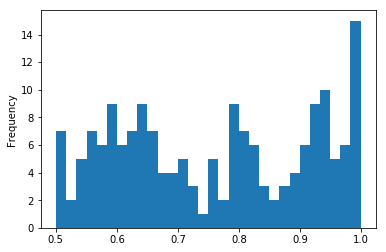

In [339]:
errors[errors.pred_galaxy_type == 0].raw_error.plot.hist(bins=30)

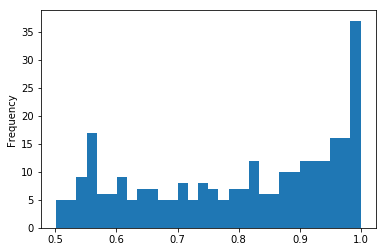

In [340]:
errors[errors.pred_galaxy_type == 1].raw_error.plot.hist(bins=30)

In [341]:
errors = pd.DataFrame(np.abs(y_test - pred) * predictions).rename(columns={'galaxy_type': 'raw_error'})
errors['error_val'] = np.abs(2 * (errors.raw_error - 0.5))
errors['pred_galaxy_type'] = pred
errors = errors[errors.raw_error > 0.0]
errors.sort_values(by=['error_val'], ascending=False)

,raw_error,error_val,pred_galaxy_type
524581,0.999209,0.998418,1
332141,0.999154,0.998309,1
142257,0.000901,0.998197,0
239859,0.998974,0.997948,1
306007,0.998802,0.997603,1
302757,0.998382,0.996763,1
438285,0.998171,0.996341,1
148677,0.002155,0.995691,0
73876,0.997840,0.995681,1
444935,0.997673,0.995347,1


In [342]:
len(x_test)

38345

In [343]:
unknown = transformed_data[transformed_data.galaxy_type == sgd.UNKNOWN_GALAXY_TYPE]
unknown.loc[unknown.debiased_elliptical > 0.75, 'galaxy_type'] = sgd.ELLIPTICAL_GALAXY_TYPE
unknown.loc[unknown.debiased_spiral > 0.75, 'galaxy_type'] = sgd.SPIRIAL_GALAXY_TYPE

X_unknown = unknown[unknown.galaxy_type != sgd.UNKNOWN_GALAXY_TYPE][base_features]
y_unknown_expected = unknown[unknown.galaxy_type != sgd.UNKNOWN_GALAXY_TYPE]['galaxy_type']
y_unknown_predictions = predict(models, X_unknown, features=base_features)

/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [344]:
y_unknown_pred = np.empty(y_unknown_predictions.shape, dtype=int)
y_unknown_pred[y_unknown_predictions < 0.5] = SPIRIAL_GALAXY_TYPE
y_unknown_pred[y_unknown_predictions >= 0.5] = ELLIPTICAL_GALAXY_TYPE

In [345]:
sgd.classification_scores(y_unknown_expected, y_unknown_pred)

[[21455   767]
 [  824 23285]]


{'recall': 0.9658218922394126,
 'specificity': 0.9654846548465484,
 'precision': 0.9681107600199568,
 'accuracy': 0.9656601411581878,
 'f1': 0.9669649716575652,
 'mcc': 0.9312158981201476}